In [2]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import numpy as np
from scipy.signal import argrelmin
%matplotlib inline
import csv
import os

In [41]:
#directory = '/users/tkm/kanilmaz/thesis/results/wg3_2/supercurrent/use/'
directory = '/home/nefta/thesis/results/wg3_2/supercurrent/use/'
#W = 918 
#L = 204
W = 360
L = 100

In [42]:
dirpath, dirnames, filenames = list(os.walk(directory))[0]
phi_sg_values = [float(filename[4:-18]) for filename in list(os.walk(directory))[0][1]]


In [43]:
def read_values(filename):
    result = []
    with open(filename) as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
            result.append([float(element) for element in row])
    return(result)

In [52]:
def flip_minima(abs_values, real_values):
    main_peak = np.argmax(abs_values) # index of main peak
    left_min = [0]
    right_min = [main_peak]
    #print(argrelmin(abs_values, order=35)[0])
    
    for loc_min in argrelmin(abs_values, order=20)[0]:
    #for loc_min in [2, 248, 305, 694, 751, 997]:

        if loc_min < main_peak:
            left_min.append(loc_min)
        else: right_min.append(loc_min)
    left_min.append(main_peak)
    right_min.append(len(abs_values))
    left_min_rev = list(reversed(left_min))
    
    #print(left_min, right_min, left_min_rev)
    osc = []
    n = len(left_min)
    for i in range(n - 1):
        #print(n-i - 1, n-i-2)
        for index in range(left_min_rev[n  - i - 1], left_min_rev[n - i - 2]):
            #osc.append((-1)**(i+1) * abs(real_values[index]))
            osc.append((-1)**(n - i) * abs(real_values[index]))
    for i in range(n - 1):
        #print(i, i+1)
        for index in range(right_min[i], right_min[i+1]):
            osc.append((-1)**i * abs(real_values[index]))
    return(osc)

In [53]:
def transform_to_density(b_values, real, imag, y_values):
    omega = 2 * np.pi / W
    
    phi_values = b_values * W * L 
    dPhi = phi_values[1] - phi_values[0]
    maxPhi = phi_values[-1]
    Jy_values = []
    for y in y_values:
        Jy_real = 0
        Jy_imag = 0
        for k, phi in list(enumerate(phi_values)):
            Ic_real = real[k] #Fourier coefficient
            Ic_imag = imag[k]
            Jy_real += abs(np.cos(np.pi * phi / (2 * maxPhi)))**0.5 * (Ic_real * np.cos(omega * phi * y) - Ic_imag * np.sin(omega * phi * y)) * dPhi
            Jy_imag += abs(np.cos(np.pi * phi / (2 * maxPhi)))**0.5 * (Ic_imag * np.cos(omega * phi * y) + Ic_real * np.sin(omega * phi * y)) * dPhi
        Jy_abs = np.sqrt(Jy_real**2 + Jy_imag**2)
        Jy_values.append(Jy_abs)
    return(Jy_values)

In [54]:
def plot_current_and_density(phi_values, abs_values, real_flip, 
                             y_values, j_values, phi_sg, filedir):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
    fig.suptitle(r'$\varphi_{{SG}} = {}$'.format(phi_sg), fontsize=20)
    ax1.plot(phi_values, abs_values, marker='o', linestyle='none', label='abs')
    ax1.plot(phi_values, real_flip, marker='o', linestyle='none', label='real, flipped')
    ax1.set_xlabel(r'$\phi / \phi_0 $', fontsize=18)
    ax1.set_ylabel(r'$I_c$', fontsize=18)
    ax1.set_xlim(phi_values[0], phi_values[-1])
    #ax1.set_ylim()
    ax1.legend()
    #ax1.grid()
    
    ax2.plot(y_values, j_values, marker='o', linestyle='none')
    ax2.set_xlabel(r'$y\ [a]$', fontsize=18)
    ax2.set_ylabel(r'$J(y)$', fontsize=18)
    ax2.set_xlim(y_values[0], y_values[-1])
    #ax2.grid()
    
    fig.savefig(filedir + '/current_and_density_{}.png'.format(phi_sg))
    fig.savefig(filedir + '/current_and_density_{}.ps'.format(phi_sg))
    return()

In [55]:
sorted(zip(phi_sg_values, dirnames))[:6]

[(-0.75, 'vsg=-0.75-20171105-14:40:17'),
 (-0.7, 'vsg=-0.7-20171105-14:36:11'),
 (-0.65, 'vsg=-0.65-20171105-14:32:04'),
 (-0.6, 'vsg=-0.6-20171105-14:27:59'),
 (-0.55, 'vsg=-0.55-20171105-14:23:53'),
 (-0.5, 'vsg=-0.5-20171105-14:19:47')]

/home/nefta/.virtualenvs/kwant/lib/python3.5/site-packages/ipykernel_launcher.py:22: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


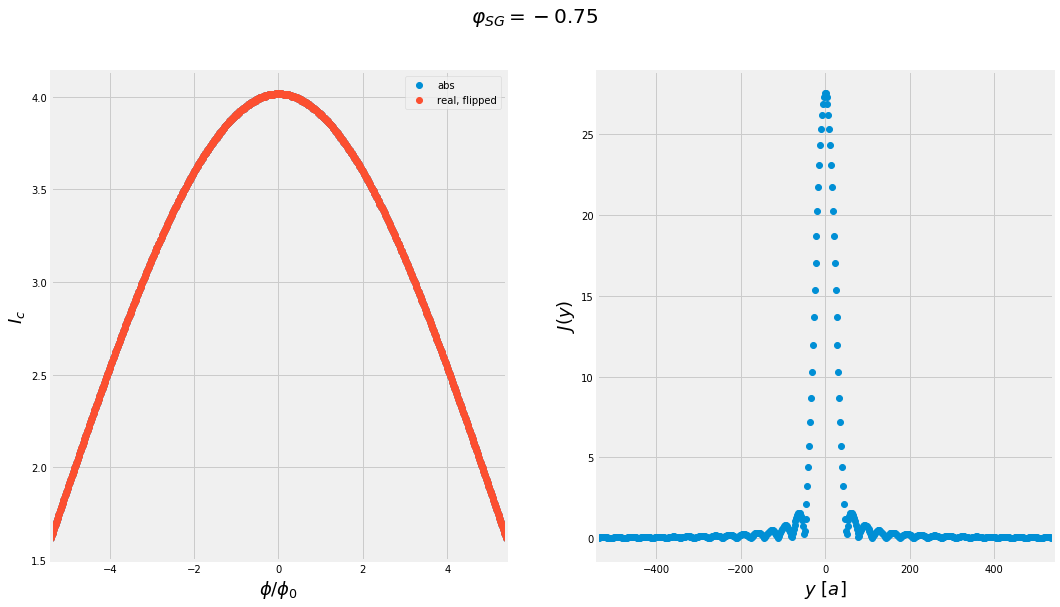

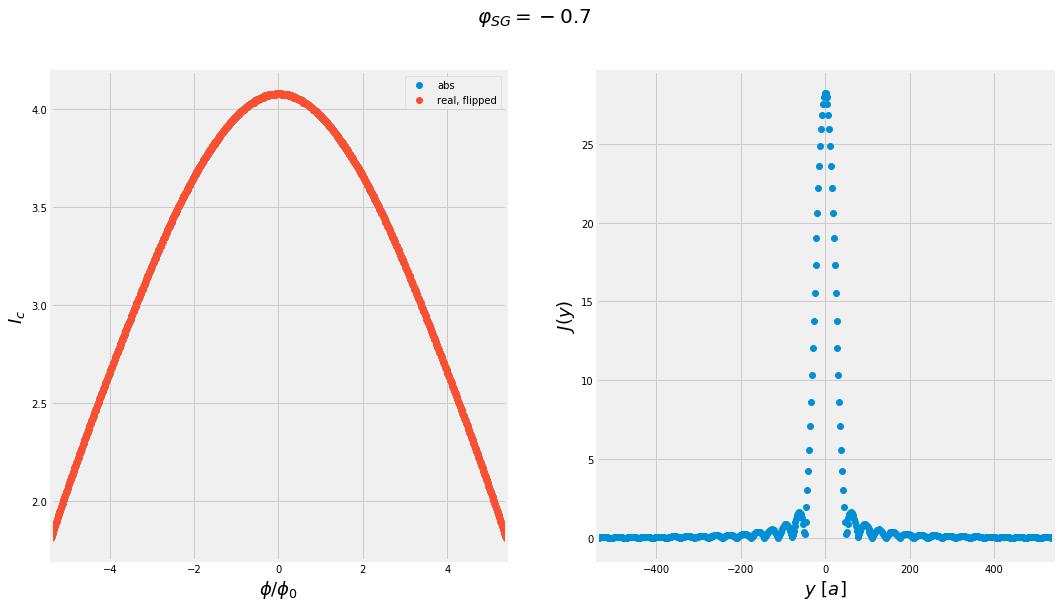

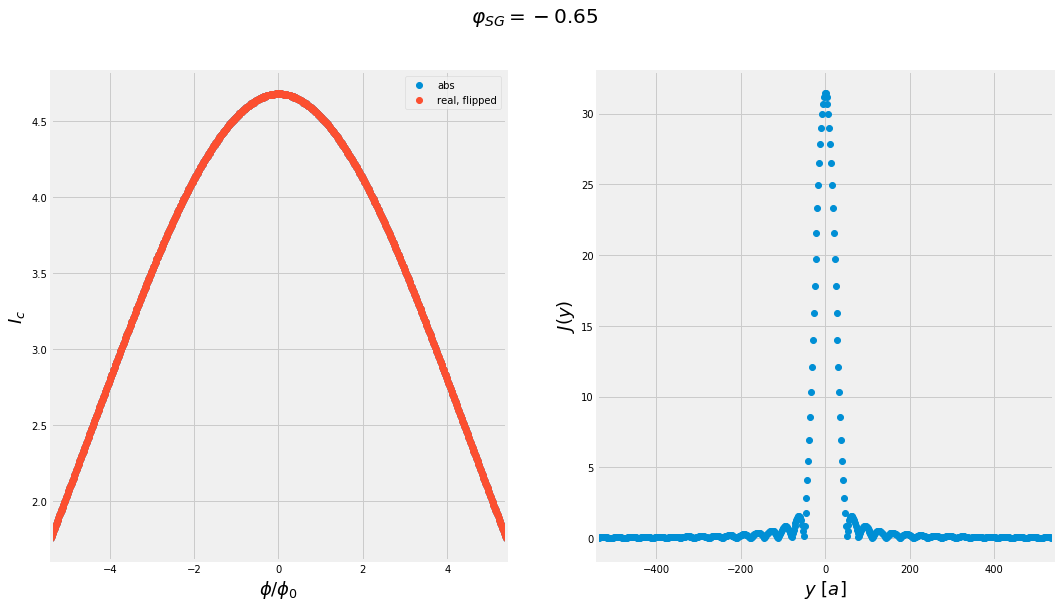

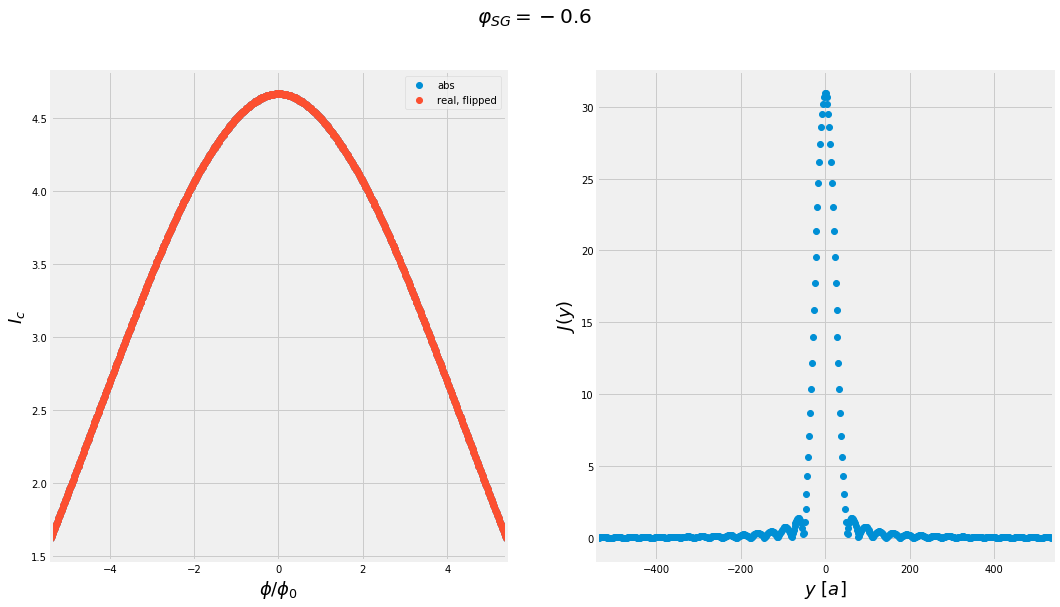

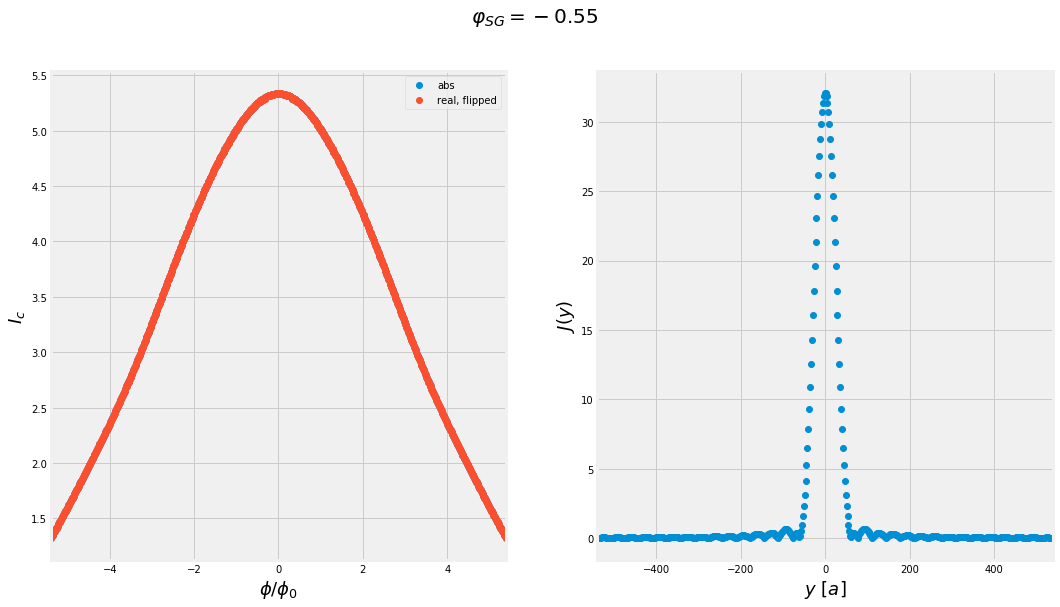

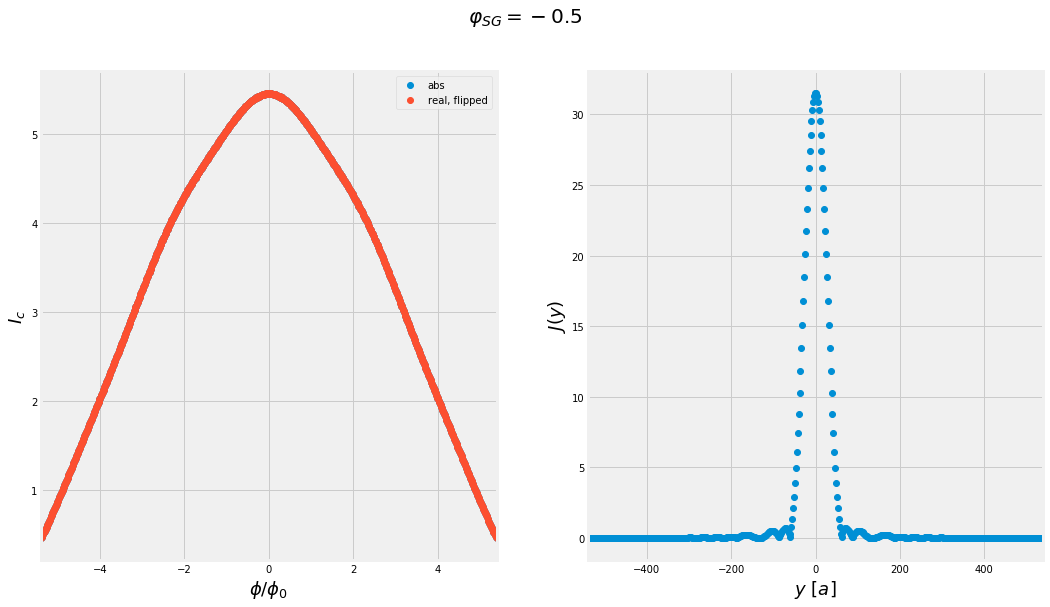

In [56]:
for phi_sg, dirname in sorted(zip(phi_sg_values, dirnames))[:6]:
#phi_sg, dirname =  sorted(zip(phi_sg_values, dirnames))[-8]
    filename = directory + dirname + '/data.csv'
    filedirectory = directory + dirname
    paramsfile = directory + dirname + '/params.txt'
    params = {}

    with open(paramsfile) as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            params[row[0]] = row[1]
    try:
        values = read_values(filename)
    except:
        print('Could not open {}'.format(filename))

    abspart, realpart, imagpart = np.asarray(values).T
    realpart_flipped = flip_minima(abspart, realpart)

    nbPoints = float(params['nb_points'])
    maxB = float(params['maxB']) 
    mag_field = np.linspace(-maxB, maxB, nbPoints)

    phi_norm = mag_field * W * L
    y = np.linspace(-1.5*W, 1.5*W, 500)
    density = transform_to_density(mag_field, realpart_flipped, imagpart, y)

    plot_current_and_density(phi_norm, abspart, realpart_flipped, 
                             y, density, phi_sg, filedirectory)


In [4]:
#datafile = '/users/tkm/kanilmaz/thesis/results/wg3_2/supercurrent/use/vsg=-0.25-20171027-13:41:59/data.csv'
datafile = '/users/tkm/kanilmaz/thesis/results/wg3_2/supercurrent/use/vsg=-0.4-20171026-13:46:14/data.csv'

In [5]:
values = np.asarray(read_imag_values(datafile)).T
absval , realval, imagval = values
maxB = 0.0001
magnetic_field = np.linspace(-maxB, maxB, 1000)

In [29]:
W = 360 # in m, scaled system size
L = 100 # in m, scaled system size
phi_norm = magnetic_field * W * L

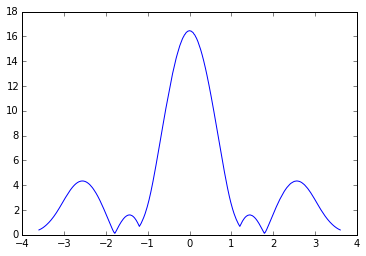

In [8]:
plt.plot(magnetic_field * W * L, absval)

In [9]:
from scipy.signal import argrelmin, argrelmax

def flip_minima(abs_values, real_values):
    main_peak = np.argmax(abs_values) # index of main peak
    left_min = [0]
    right_min = [main_peak]
    for loc_min in argrelmin(abs_values, order=2)[0]:
        if loc_min < main_peak:
            left_min.append(loc_min)
        else: right_min.append(loc_min)
    left_min.append(main_peak)
    right_min.append(len(abs_values))
    left_min_rev = list(reversed(left_min))
    
    print(left_min, right_min, left_min_rev)
    osc = []
    n = len(left_min)
    for i in range(n - 1):
        #print(n-i - 1, n-i-2)
        for index in range(left_min_rev[n  - i - 1], left_min_rev[n - i - 2]):
            #osc.append((-1)**(i+1) * abs(real_values[index]))
            osc.append((-1)**(n - i) * abs(real_values[index]))

    for i in range(n - 1):
        #print(i, i+1)
        for index in range(right_min[i], right_min[i+1]):
            osc.append((-1)**i * abs(real_values[index]))

    return(osc)
    

In [17]:
W = 360
y = np.linspace(-2*W, 2*W, 500)
real_flipped = flip_minima(absval, realval)
density = transform_to_density(magnetic_field, (real_flipped, imagval), y)

[0, 251, 333, 499] [499, 666, 748, 1000] [499, 333, 251, 0]


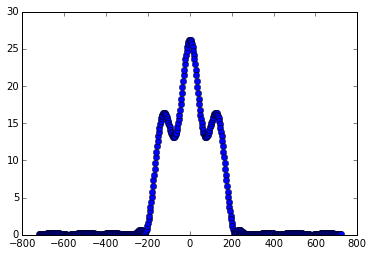

In [18]:
plt.plot(y, density, linestyle='none', marker='o')

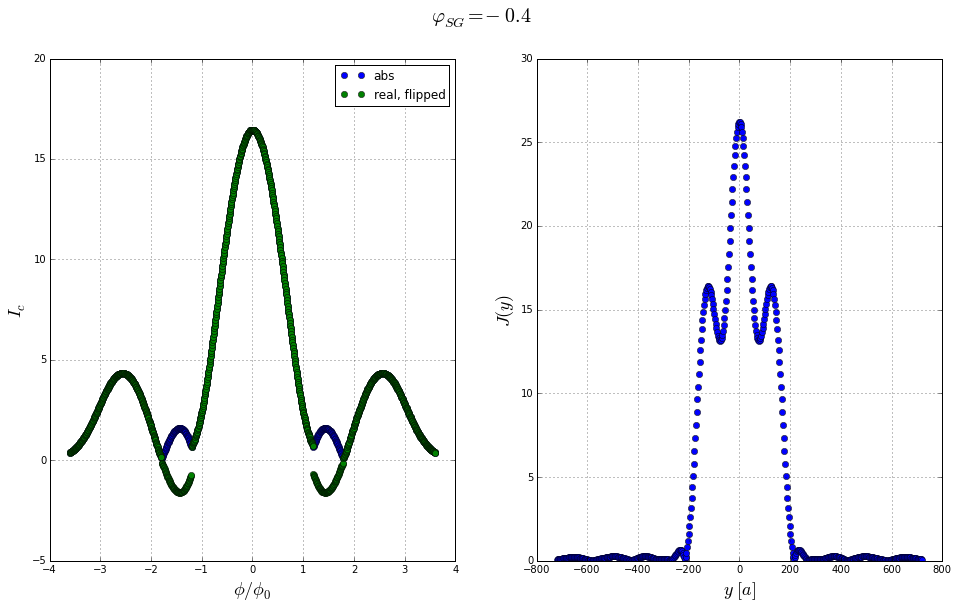

In [48]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
fig.suptitle(r'$\varphi_{SG} = -\ 0.4$', fontsize=20)
ax1.plot(phi_norm, absval, marker='o', linestyle='none', label='abs')
ax1.plot(phi_norm, real_flipped, marker='o', linestyle='none', label='real, flipped')
ax1.set_xlabel(r'$\phi / \phi_0 $', fontsize=18)
ax1.set_ylabel(r'$I_c$', fontsize=18)
ax1.legend()
ax1.grid()
ax2.plot(y, density, marker='o', linestyle='none')
ax2.set_xlabel(r'$y\ [a]$', fontsize=18)
ax2.set_ylabel(r'$J(y)$', fontsize=18)
ax2.grid()


In [14]:
file2 = '/home/nefta/thesis/results/wg3_2/supercurrent/vsg=-0.4-20171026-13:46:14/data.csv'
values2 = np.asarray(read_imag_values(file2)).T

#density2 = transform_to_density(magnetic_field, (values[0], values[1]), y)

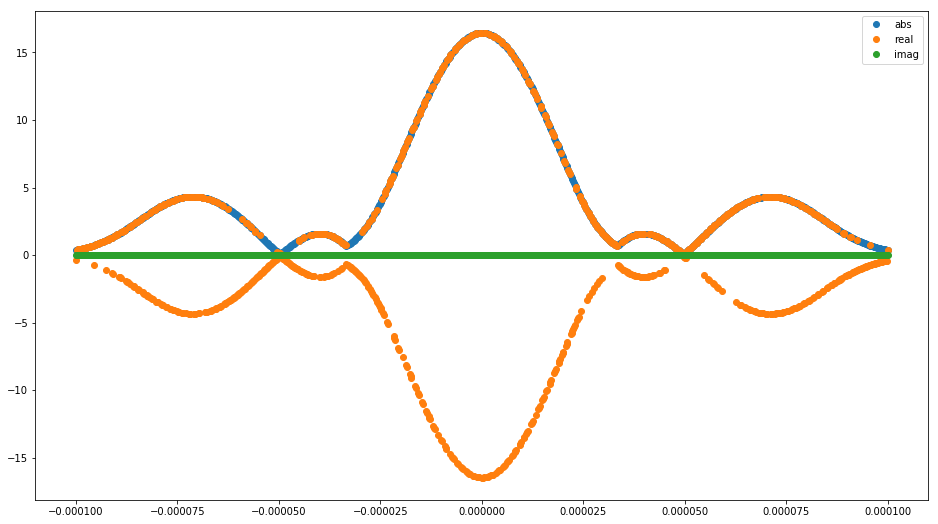

In [15]:
fig, ax = plt.subplots(figsize=(16, 9))
for index, labelname in enumerate(['abs', 'real', 'imag']):
    ax.plot(magnetic_field, values2[index], label=labelname, linestyle='none', marker='o')
ax.legend()

In [84]:
np.argmax(values2[0])

499

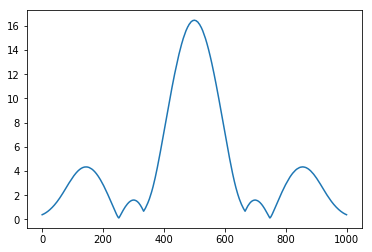

In [105]:
plt.plot(values2[0])

[0, 251, 333, 499] [499, 666, 748, 1000] [499, 333, 251, 0]


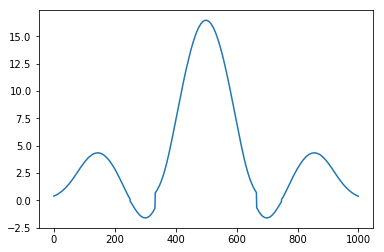

In [118]:
plt.plot(flip_minima(abs_values=values2[0], real_values=values2[1]))

In [110]:
file3 = '/home/nefta/thesis/results/wg3_2/supercurrent/vsg=-0.3-20171026-13:40:36/data.csv'
values3 = np.asarray(read_imag_values(file3)).T

[0, 53, 225, 351, 497] [497, 648, 774, 946, 1000] [497, 351, 225, 53, 0]


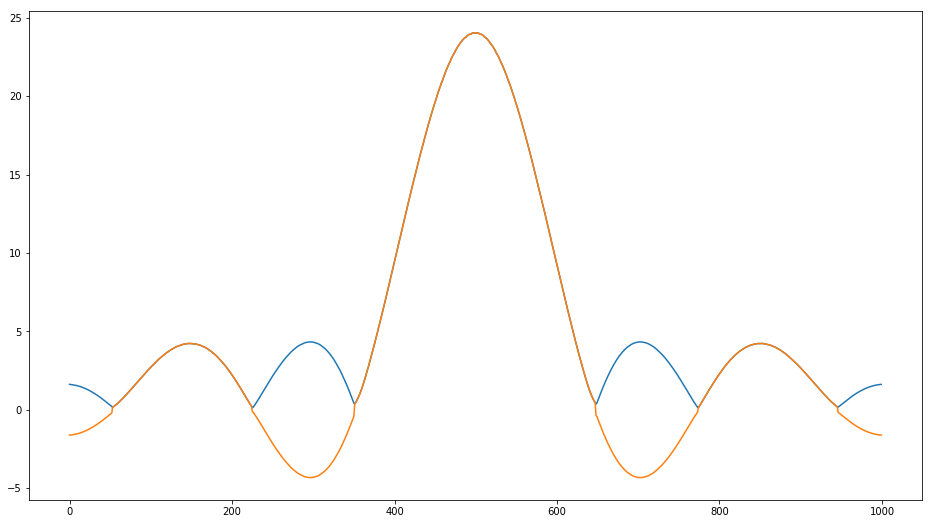

In [119]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(values3[0])
ax.plot(flip_minima(values3[0], values3[1]))

In [115]:
argrelmin(values3[0])

(array([ 53, 150, 225, 351, 648, 774, 849, 946]),)

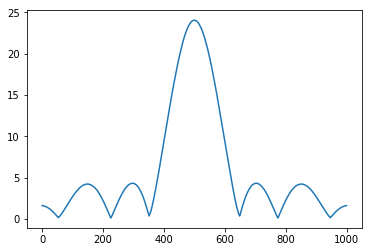

In [116]:
plt.plot(values3[0])